In [1]:
import FINE as fn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 1. Create an energy system model instance 

In [2]:
locations = {'bd1'}
commodityUnitDict = {'electricity': 'kW_el','heatRoom':'kW_th','heatConcrete':'kw_th','coldRoom':'kw_th'}
commodities = {'electricity','heatRoom','heatConcrete','coldRoom'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e Euro', lengthUnit='km', verboseLogLevel=0)

# 2. Add commodity sources to the energy system model

## 2.1. Electricity sources

### 2.1.1 Electricity purchase from grid

In [4]:
esM.add(fn.Source(esM=esM, name='Electricity purchase', commodity='electricity', hasCapacityVariable=False,
                  commodityCost=0.298))

### 2.1.2 PV

In [5]:
# Input parameters
name, commodity ='PV', 'electricity'
hasCapacityVariable = True
dailyProfileSimple = [0,0,0,0,0,0,0,0.05,0.15,0.2,0.4,0.8,0.7,0.4,0.2,0.15,0.05,0,0,0,0,0,0,0]
operationRateMax = pd.DataFrame([u*np.sin(day*np.pi/365)**10 for day in range(365) for u in dailyProfileSimple],
                                index=range(8760),columns=['bd1'])
capacityMax = None
investPerCapacity, opexPerCapacity = 0.1*800, 0.1*800*0.02
interestRate, economicLifetime = 0.08, 25

# If data should be read from an excel file:
#writer = pd.ExcelWriter('PV_Profile.xlsx') # writes data to an excel file
#operationRateMax.to_excel(writer)                  # (not required if excel file
#writer.save()                                      #  already exists)
#operationRateMax = pd.read_excel('PV_Profile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityMax=capacityMax, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

# 3. Add conversion components to the energy system model

### 3.1 Heatpump heatRoom from Source Air

In [6]:
esM.add(fn.Conversion(esM=esM,
                      name='Heatpump Air',
                      physicalUnit = 'kW_th',
                      commodityConversionFactors={'electricity':-1/2, 'heatRoom':1},
                      hasIsBuiltBinaryVariable=True,
                      hasCapacityVariable=True,
                      interestRate = 0.08,
                      economicLifetime = 20,
                      investIfBuilt=2800,
                      investPerCapacity=725,
                      opexPerCapacity = 725*0.02,
                      bigM = 2000))

### 3.2 Heatpump heatRoom from Source Concrete

In [7]:
esM.add(fn.Conversion(esM=esM,
                      name='Heatpump Concrete',
                      physicalUnit = 'kW_th',
                      commodityConversionFactors={'electricity':-1/6,'heatConcrete':-1,'heatRoom':1},
                      hasIsBuiltBinaryVariable=True,
                      hasCapacityVariable=True,
                      interestRate = 0.08,
                      economicLifetime = 20,
                      investIfBuilt=2800,
                      investPerCapacity=725,
                      opexPerCapacity = 725*0.02,
                      bigM = 2000))

### 3.3 Coldpump coldRoom via heatRoom to Sink Concrete

In [8]:
esM.add(fn.Conversion(esM=esM,
                      name='Coldpump Concrete',
                      physicalUnit = 'kW_th',
                      commodityConversionFactors={'electricity':-1/6,'coldRoom':1,'heatConcrete':1},
                      hasIsBuiltBinaryVariable=True,
                      hasCapacityVariable=True,
                      interestRate = 0.08,
                      economicLifetime = 20,
                      investIfBuilt=2800,
                      investPerCapacity=725,
                      opexPerCapacity = 725*0.02,
                      bigM = 2000))

# 4. Add commodity storages to the energy system model

## 4.1.  Heat

### 4.1.1 Concrete: heatConcrete

In [9]:
esM.add(fn.Storage(esM=esM,
                   name='Thermal Storage Concrete',
                   commodity='heatConcrete',
                   selfDischarge=0.001,
                   hasIsBuiltBinaryVariable=True,
                   capacityMax=None,
                   interestRate = 0.04,
                   economicLifetime = 25,
                   investIfBuilt=0,
                   investPerCapacity=0,
                   bigM = 250000))

## 4.2 Electricity
### 4.2.1 Li-Ion

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [10]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, capacityMax=20, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

# 5. Add commodity sinks to the energy system model

## 5.1. Cold sinks

### Demand: coldRoom

In [11]:
(np.heaviside(0.8-0.9,0))

0.0

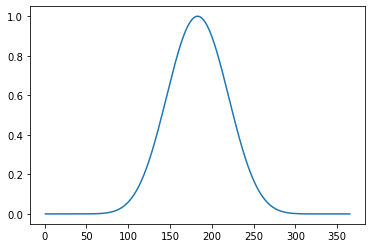

In [12]:
## pretesting seasonal cold demand
x = np.linspace(0,np.pi,365)   # start,stop,number of steps
y = np.sin(x)**10
plt.plot(np.arange(1,366,1),y)
plt.show()

In [13]:
dailyProfileSimple = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

operationRateFix = pd.DataFrame([[(u+0.1*np.random.rand())*100*np.sin(day*np.pi/365)**10]
                                 for day in range(365) for u in dailyProfileSimple],
                                index=range(8760),columns=['bd1']).round(2)

# If data should be read from an excel file:
#writer = pd.ExcelWriter('demandColdProfile.xlsx') # writes data to an excel file
#operationRateFix.to_excel(writer)                  # (not required if excel file
#writer.save()                                      #  already exists)
#operationRateFix = pd.read_excel('demandColdProfile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory

esM.add(fn.Sink(esM=esM, name='BuildingsCold', commodity='coldRoom',
                hasCapacityVariable=False, operationRateFix=operationRateFix))

## 5.2 Heat sinks

### 5.2.1 Demand: heatRoom

In [14]:
dailyProfileSimple = [0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0]
operationRateFix = pd.DataFrame([[(u+0.1*np.random.rand())*5]
                                 for day in range(365) for u in dailyProfileSimple],
                                index=range(8760),columns=['bd1']).round(2)

# If data should be read from an excel file:
#writer = pd.ExcelWriter('demandHeatProfile.xlsx') # writes data to an excel file
#operationRateFix.to_excel(writer)                  # (not required if excel file
#writer.save()                                      #  already exists)
#operationRateFix = pd.read_excel('demandHeatProfile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory

esM.add(fn.Sink(esM=esM, name='BuildingsHeat', commodity='heatRoom',
                hasCapacityVariable=False, operationRateFix=operationRateFix))

# 6. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [15]:
esM.cluster(numberOfTypicalPeriods=30)


Clustering time series data with 30 typical periods and 24 time steps per period...
		(2.1489 sec)



In [16]:
esM.optimize(timeSeriesAggregation=True, solver='glpk')

Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.9670 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2032 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8461 sec)

Declaring shared potential constraint...
		(0.0005 sec)

Declaring commodity balances...
		(0.3689 sec)

Declaring objective function...
		(0.0834 sec)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/kd/q1vc0lx55c39v3mqf3b3zd080000gq/T/tmpwh9so0yz.glpk.raw
 --wglp /var/folders/kd/q1vc0lx55c39v3mqf3b3zd080000gq/T/tmpf9jdjih1.glpk.glp
 --cpxlp /var/folders/kd/q1vc0lx55c39v3mqf3b3zd080000gq/T/t

# 7. Selected results output

### Sources and Sink

Show optimization summary

In [17]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

bd1
Component            Property    Unit                
BuildingsCold        operation   [kw_th*h/a]  73507.1
BuildingsHeat        operation   [kW_th*h/a]  22279.9
Electricity purchase TAC         [1e Euro/a]  1735.17
                     commodCosts [1e Euro/a]  1735.17
                     operation   [kW_el*h/a]  5822.73
PV                   TAC         [1e Euro/a]  777.208
                     capacity    [kW_el]      85.4609
                     capexCap    [1e Euro/a]   640.47
                     invest      [1e Euro]    6836.87
                     operation   [kW_el*h/a]  15405.6
                     opexCap     [1e Euro/a]  136.737

Plot operation time series (either one or two dimensional)

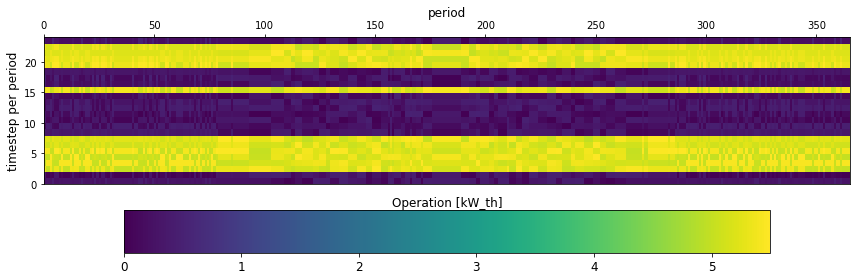

In [18]:
fig1, ax = fn.plotOperationColorMap(esM, 'BuildingsHeat', 'bd1')

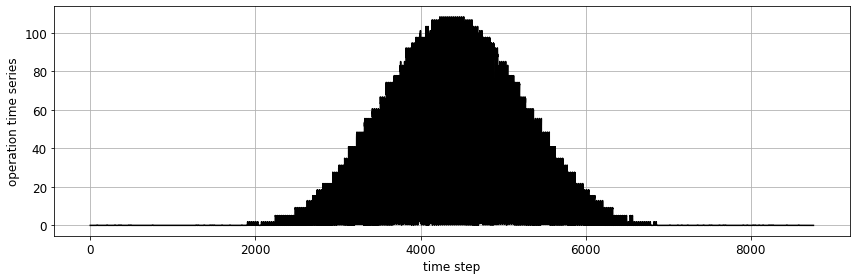

In [19]:
fig2, ax = fn.plotOperation(esM, 'BuildingsCold', 'bd1')

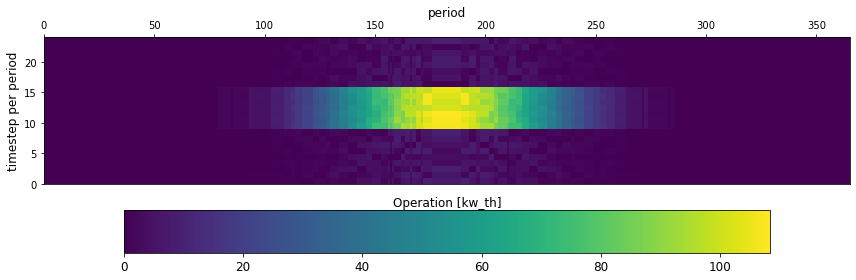

In [20]:
fig3, ax = fn.plotOperationColorMap(esM, 'BuildingsCold', 'bd1')

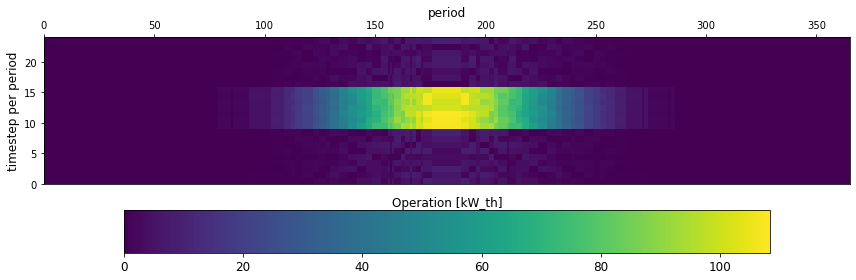

In [21]:
fig4, ax = fn.plotOperationColorMap(esM, 'Coldpump Concrete', 'bd1')


### Conversion

Show optimization summary

In [22]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

bd1
Component         Property     Unit                
Coldpump Concrete TAC          [1e Euro/a]  9855.56
                  capacity     [kW_th]      108.332
                  capexCap     [1e Euro/a]  7999.56
                  capexIfBuilt [1e Euro/a]  285.186
                  invest       [1e Euro]    81340.8
                  isBuilt      [-]                1
                  operation    [kW_th*h/a]  73507.1
                  opexCap      [1e Euro/a]  1570.82
Heatpump Air      TAC          [1e Euro/a]   714.13
                  capacity     [kW_th]      4.85545
                  capexCap     [1e Euro/a]   358.54
                  capexIfBuilt [1e Euro/a]  285.186
                  invest       [1e Euro]     6320.2
                  isBuilt      [-]                1
                  operation    [kW_th*h/a]  13122.9
                  opexCap      [1e Euro/a]   70.404
Heatpump Concrete TAC          [1e Euro/a]  694.076
                  capacity     [kW_th]      4.62845
                  capexCap     [1e Euro/a]  341.778
                  capexIfBuilt [1e Euro/a]  285.186
                  invest       [1e Euro]    6155.62
                  isBuilt      [-]                1
                  operation    [kW_th*h/a]  9157.03
                  opexCap      [1e Euro/a]  67.1125

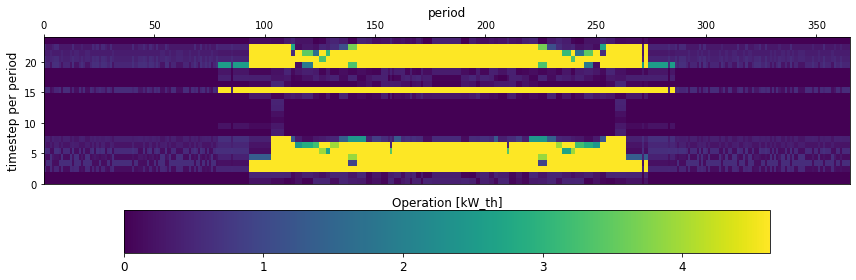

In [23]:
fig5, ax = fn.plotOperationColorMap(esM, 'Heatpump Concrete', 'bd1')

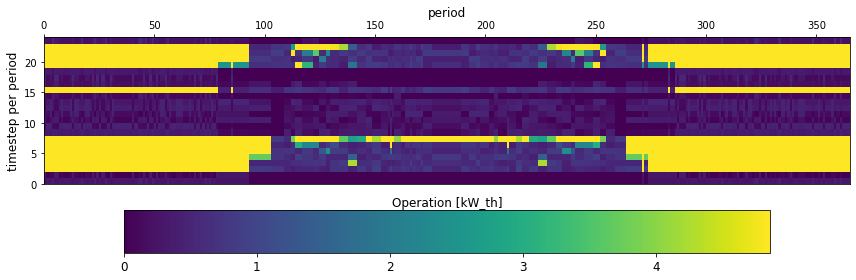

In [24]:
fig6, ax = fn.plotOperationColorMap(esM, 'Heatpump Air', 'bd1')

### Storage

Show optimization summary

In [25]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

bd1
Component                Property           Unit                 
Li-ion batteries         TAC                [1e Euro/a]  0.336057
                         capacity           [kW_el*h]          20
                         capexCap           [1e Euro/a]  0.296057
                         invest             [1e Euro]        3.02
                         operationCharge    [kW_el*h/a]   9090.91
                         operationDischarge [kW_el*h/a]   8201.34
                         opexCap            [1e Euro/a]      0.04
Thermal Storage Concrete capacity           [kw_th*h]     24416.9
                         isBuilt            [-]                 1
                         operationCharge    [kw_th*h/a]     68972
                         operationDischarge [kw_th*h/a]   4621.93

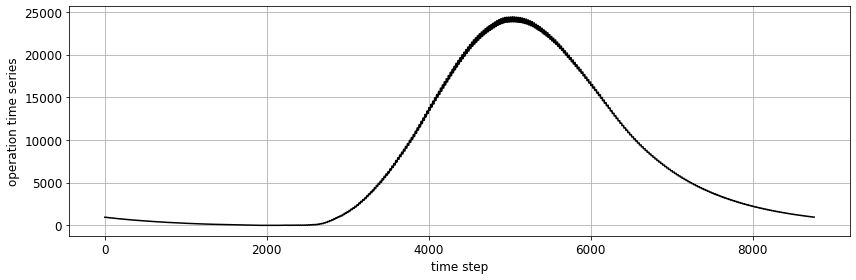

In [26]:
fig7, ax = fn.plotOperation(esM, 'Thermal Storage Concrete', 'bd1', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

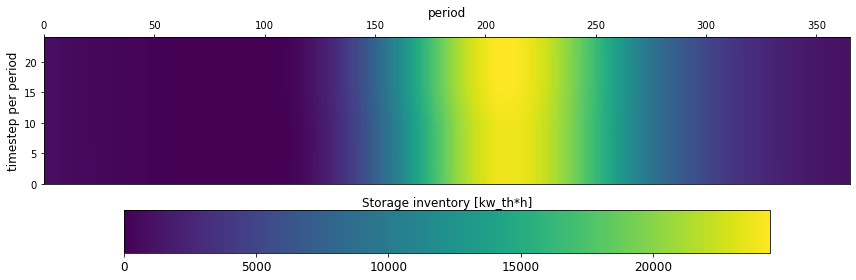

In [27]:
fig8, ax = fn.plotOperationColorMap(esM, 'Thermal Storage Concrete', 'bd1', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

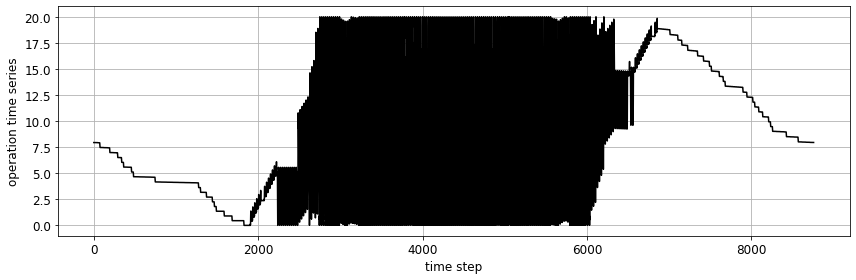

In [28]:
fig7, ax = fn.plotOperation(esM, 'Li-ion batteries', 'bd1', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

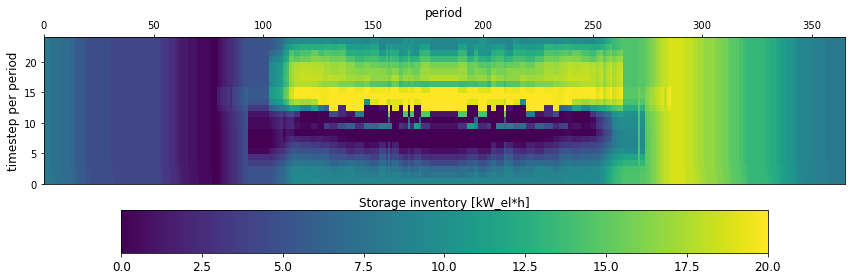

In [29]:
fig7, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'bd1', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

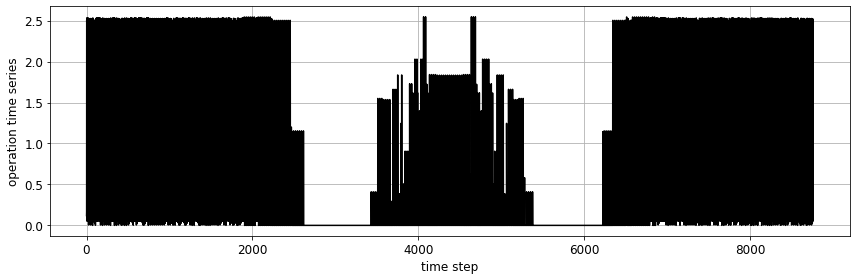

In [30]:
fig9, ax = fn.plotOperation(esM, 'Electricity purchase', 'bd1')

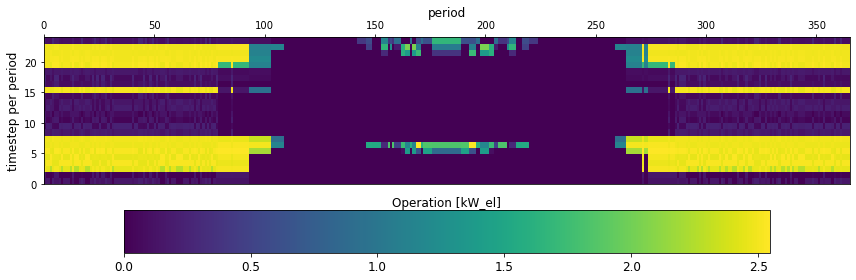

In [31]:
fig9a, ax = fn.plotOperationColorMap(esM, 'Electricity purchase', 'bd1')

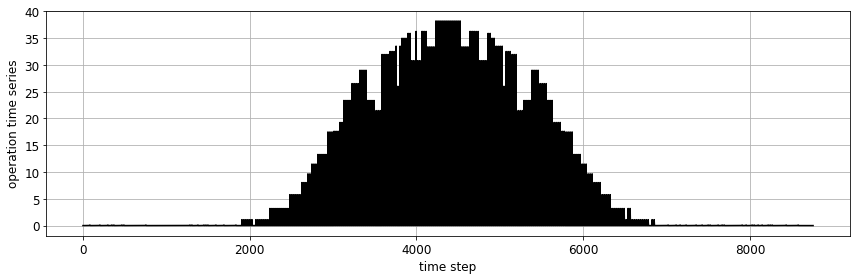

In [32]:
fig10, ax = fn.plotOperation(esM, 'PV', 'bd1')

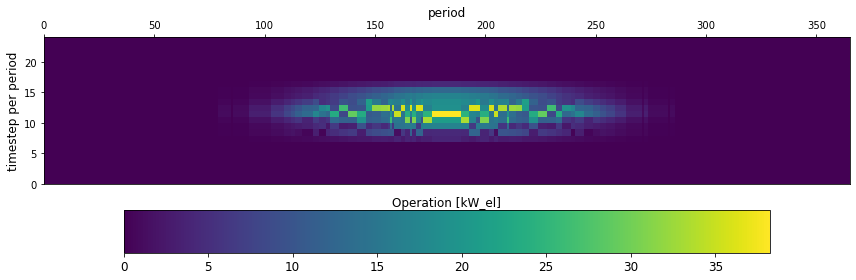

In [33]:
fig11, ax = fn.plotOperationColorMap(esM, 'PV', 'bd1')

In [79]:
import matplotlib.gridspec as gridspec

def create_figure(plot1_f1,plot1_f2):
    fig = plt.figure(constrained_layout=True, figsize=(10,8))
    specs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig) ## Declaring 2x2 figure.

    ax1 = fig.add_subplot(specs[0, :]) ## First Row
    fig, ax1 = fn.plotOperationColorMap(esM, plot1_f1, 'bd1')
    ax2 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
    fig, ax2 = fn.plotOperationColorMap(esM, plot1_f2, 'bd1')    
    plt.close(fig)
    return fig

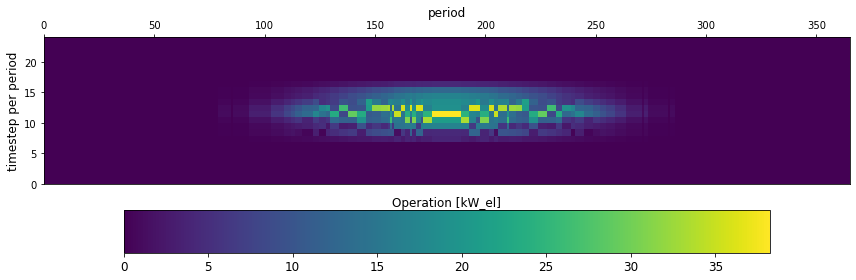

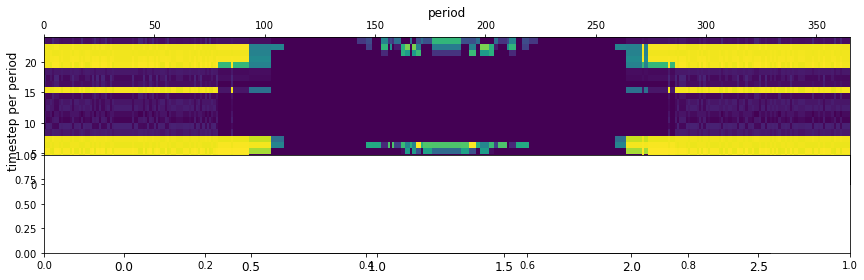

In [80]:
create_figure('Electricity purchase','PV')

Column
    [0] Column
        [0] Select(name='plot1_f1', options=['Electricity purchase', ...], value='Electricity purchase')
    [1] Row
        [0] Matplotlib(Figure, name='interactive00007')
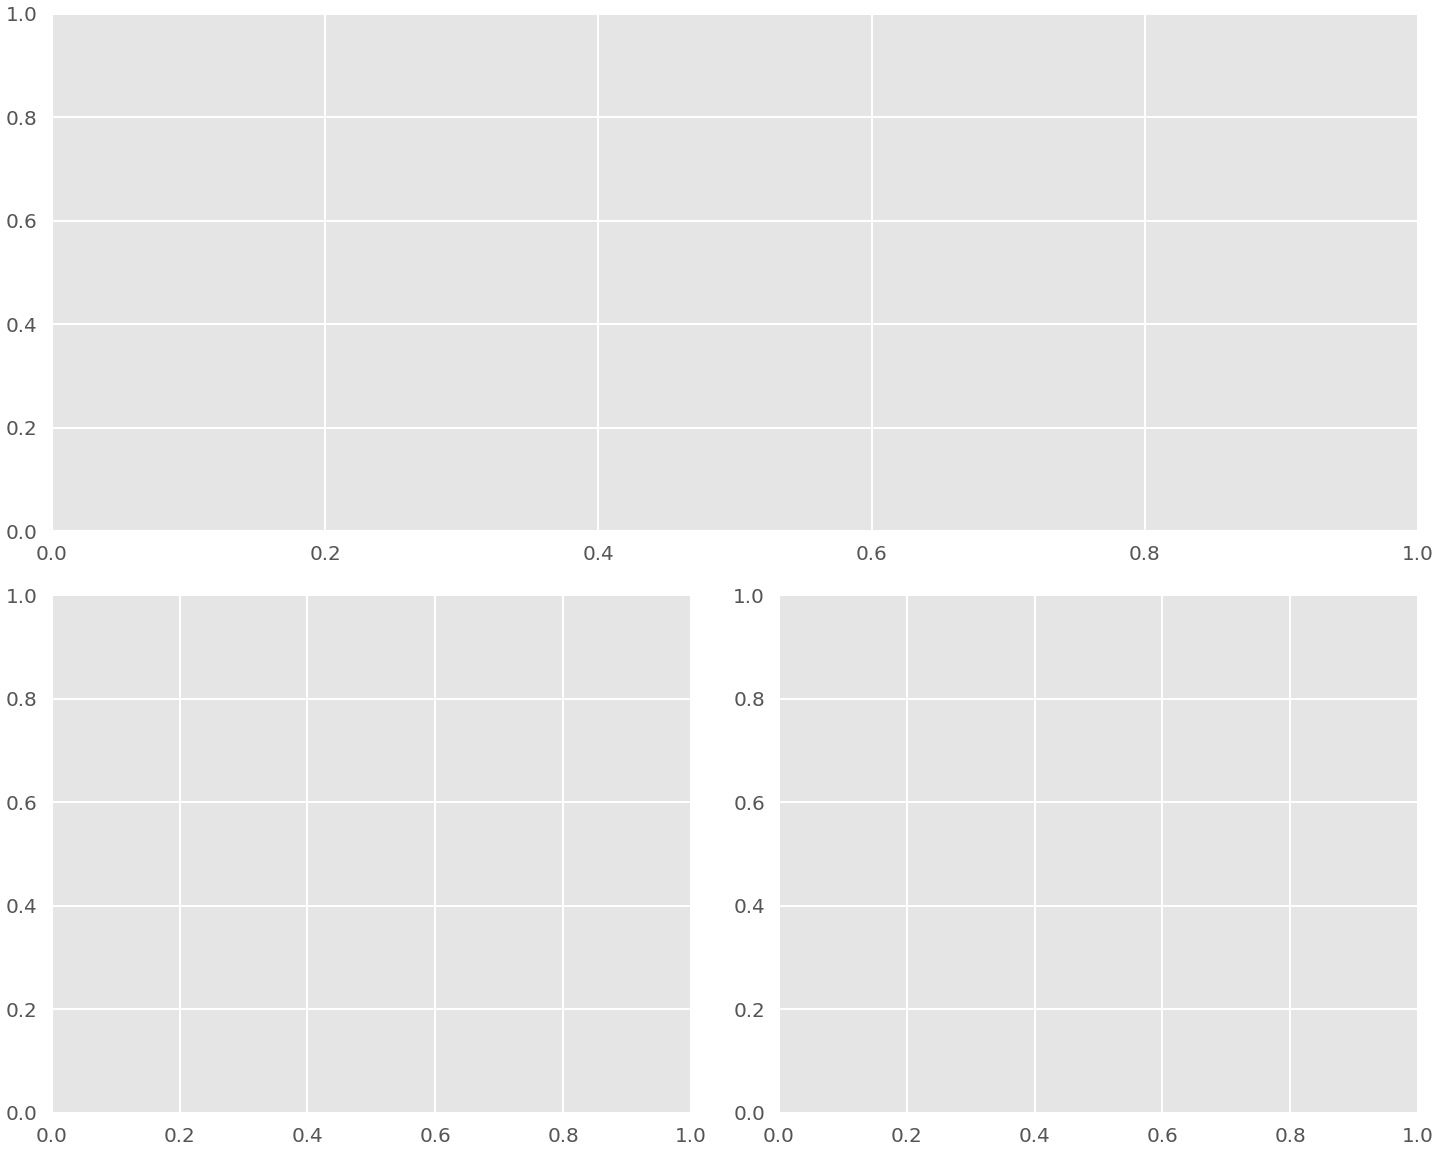

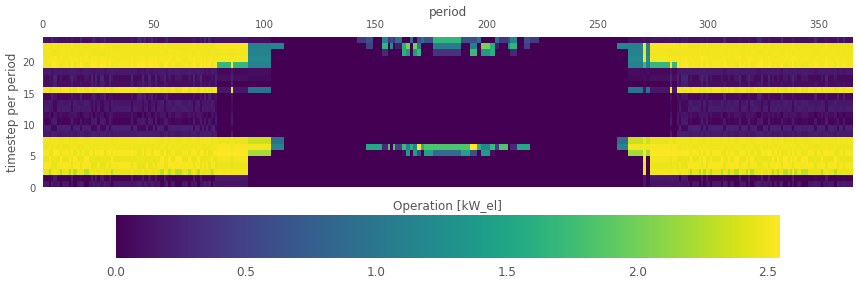

In [36]:
import panel as pn
pn.extension()

kw = dict(plot1_f1=esM.componentNames.keys())

dash1 = pn.interact(create_figure, **kw)
dash1


In [37]:
esM.componentNames.keys()

dict_keys(['Electricity purchase', 'PV', 'Heatpump Air', 'Heatpump Concrete', 'Coldpump Concrete', 'Thermal Storage Concrete', 'Li-ion batteries', 'BuildingsCold', 'BuildingsHeat'])

(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='period', ylabel='timestep per period'>)

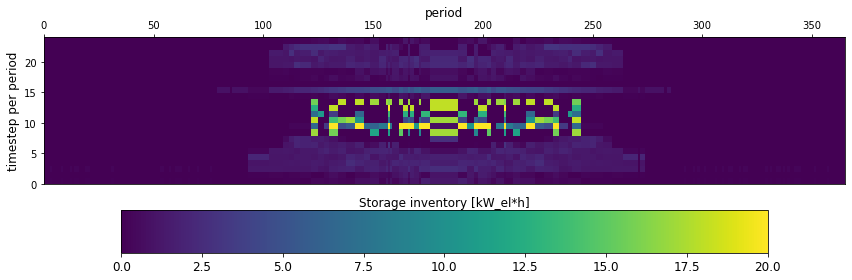

In [44]:
fn.plotOperationColorMap(esM, 'Li-ion batteries', 'bd1', 
                                   variableName='dischargeOperationVariablesOptimum')